# Лабораторная работа №2. Линейные модели для задач регрессии
## ПМ-21М
## Егор Решетников
### Вариант 6
В данной лабораторной работе рассматриваются задачи регрессии.
Частным случаем является задача линейной регрессии.
Используется следующая модель:
$$
y = \sum_{k=0}^{M-1} w_k \phi_k(\mathbf{x}) = \mathbf{w}^T \mathbf{\phi}(\mathbf{x}),
$$
где $\mathbf{\phi}(\mathbf{x}) = \left(1, \phi_1(\mathbf{x}), \dots, \phi_{M-1}(\mathbf{x})\right)^T$,
$\mathbf{w} = \left(w_0, w_1, \dots, w_{M-1}\right)^T$.

В данной работе в качестве функции штрафа используется средняя квадратичная ошибка:
$$
E_D(\mathbf{w}, \mathbf{T}) = \frac{1}{2} \sum_{n=1}^{N} \left( t_n - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) \right)^2.
$$

Решение задачи минимизации такого штрафа даёт параметры распознавателя
$$
\mathbf{w_{ML}} = \left(\mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^T \mathbf{T}.
$$

В случае добавления $L2$-регуляризации (гребневая регрессия) штраф:
$$
E(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N} \left( t_n - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) \right)^2 + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w},
$$
МНК-решением будет
$$
\mathbf{w_{ML}} = \left(\mathbf{\Phi}^T \mathbf{\Phi} + \lambda \mathbf{E} \right)^{-1} \mathbf{\Phi}^T \mathbf{T}.
$$

In [2]:
import numpy as np
import sklearn as sk
from sklearn import datasets, model_selection, metrics
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.grid'] = True

## Задание №1

Реализуйте функцию, которая возвращает параметры модели, найденные с помощью метода наименьших квадратов.
Операция умножения в `numpy` - это `np.matmul` или `@`.
Перевод массива в тип матрица осуществляется с помощью `np.asmatrix`.
Транспонирование матрицы `x` - это операция `x.T`.
Получение из матрицы `x` линейный массив - это операция `x.A1`.

In [6]:
class LeastSquare:
    def __init__(self, x, y):
        ones = np.asmatrix(np.repeat(1, len(x))).T
        x = np.concatenate((ones, x), axis=1)
        self.w = np.linalg.inv(x.T @ x) @ x.T @ np.asmatrix(y).T
    
    def __call__(self, x):
        ones = np.asmatrix(np.repeat(1, len(x))).T
        x = np.concatenate([ones, x], axis=1)
        return (x @ self.w).A1

# Тестирование

test_x = np.array([[1, 1, 1], [2, 2**2, 2**3], [3, 3**2, 3**3], [4, 4**2, 4**3]])
lsm = LeastSquare(test_x, [-1, 1, 2, 3])
assert np.linalg.norm(lsm(test_x) - [-1, 1, 2, 3]) < 1e-9, 'Метод недостаточно точный'

## Задание №2

Сгенерируйте данные для регрессии.
Размер выборки определяется соотношением `100 + 50 * mod(<порядковый номер в группе>, 5)`.
Разделите полученную выборку на обучающую и тестовую.
Размер тестовой выборки должен составлять 20% от размера изначальной выборки.

In [7]:
x, y = sk.datasets.make_regression(n_samples=(150), n_features=1, noise=1.5, bias=13, random_state=125)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=25)
print(x_train.shape, y_train.shape, y_test.shape)

(120, 1) (120,) (30,)


Запустите МНК для сгенерированного датасета.
Постройте графики, на которых изображены истинные и предсказанные значения, для тестовой и обучающей выборки.
Приведите значения MSE-ошибки для обеих выборок на тестовой и обучающей части.
$$
MSE = \frac{1}{N} \sum_{n=0}^{N-1} \left( t_n - y_n \right)^2.
$$
Сравните ошибки на обучающей и тестовой выборках, сделайте выводы.

Ошибка на обучающей выборке 2.027556116133594
Ошибка на тестовой выборке 1.9832680168957793


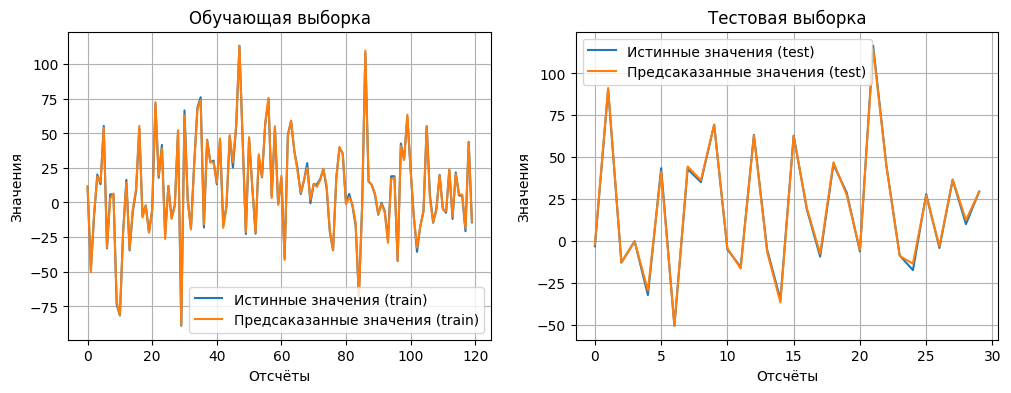

In [9]:
regressor = LeastSquare(x_train, y_train)

ry_train, ry_test = regressor(x_train), regressor(x_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))

ax0.plot(y_train, label='Истинные значения (train)')
ax0.plot(ry_train, label='Предсаказанные значения (train)')
ax0.set(xlabel='Отсчёты', ylabel='Значения', title='Обучающая выборка')
ax0.legend()


ax1.plot(y_test, label='Истинные значения (test)')
ax1.plot(ry_test, label='Предсаказанные значения (test)')
ax1.set(xlabel='Отсчёты', ylabel='Значения', title='Тестовая выборка')
ax1.legend()

print('Ошибка на обучающей выборке', sk.metrics.mean_squared_error(y_train, ry_train))
print('Ошибка на тестовой выборке', sk.metrics.mean_squared_error(y_test, ry_test))

## Задание №3

Реализуйте функцию, вычисляющую веса $w$ методом градиентного спуска:
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \eta \nabla E (\mathbf{w}_i, T),\; i = 1,2,\dots , \\
E(w) = \frac{1}{2} \sum_{n=0}^{N-1} \left( t_n - \mathbf{w}^T\mathbf{\phi}(\mathbf{x}_n) \right)^2, \\
\nabla E(\mathbf{w}) = \mathbf{\Phi}^T(\mathbf{\Phi}\mathbf{w} - \mathbf{T}).
$$
c условием выхода:
$$
| E_i - E_{i-1} | < \varepsilon \; \mathrm{или} \; N_{iter} \ge N_{max},
$$
где $N_{iter}$ $-$ номер итерации.
Здесь полагаем, что $\mathbf{\phi}(\mathbf{x}) = \mathbf{x}$.

In [50]:
class GradientDescent:
    def __init__(self, x, y, eta=0.001, eps=1e-6, n_iter=5000):
        self.eta, self.eps, self.n_iter = eta, eps, n_iter
        rng = np.random.default_rng(seed=42)
        self.w = rng.uniform(size=x.shape[-1] + 1)
        ones = np.ones((len(y),1))
        x = np.concatenate((ones, x), axis = -1)
        y = np.array(y)
        eprev = 0
        e = np.sum((y - self.w @ x.T) ** 2) / 2

        n = 0
        for i in range(self.n_iter):
            self.w -= eta * (x.T @ ((x @ self.w) - y))
            eprev = e
            if (eprev < eps):
                break
            e = np.sum((y - self.w @ x.T) ** 2) / 2
            n = i
        self.last_iter, self.last_error, self.last_error_delta = n, e, abs(eprev - e)
        
    def __call__(self, x):
        ones = np.ones((x.shape[0],1))
        x = np.concatenate((ones, x), axis = 1)
        return self.w @ x.T

# Тестирование
test_x = np.array([[0, 1, 2], [3, 4, 5]])
gd = GradientDescent(test_x, [-1, 1])
assert np.linalg.norm(gd(test_x) - [-1, 1]) < 1, 'Метод недостаточно точный'

Запустите полученную модель для датасета.
Сравните ошибки на выборках, полученные методом градиентного спуска.
Выведите количество итераций, за которое модель достигла нужной точности.

**Замечание**.
Чтобы добиться приемлемых результатов (малого значения MSE), возможно, потребуется подобрать подходящие параметры шага градиентного спуска $\eta$ и максимального количества итераций. Для начала возьмите:

* $w_0 = \left( {w_0}_0, {w_0}_1, \dots, {w_0}_{n-1} \right)$, где каждая компонента ${w_0}_i$ распределена равномерно на отрезке $[-1, 1]$;
* $\eta = 10^{-3}$; 
* $\varepsilon = 10^{-6}$;
* $N_{max} = 5000$.

Ошибка на обучающей выборке 2.0275561161335935
Ошибка на тестовой выборке 1.9832680168958072
Статистика: 4999 121.6533669680156 0.0


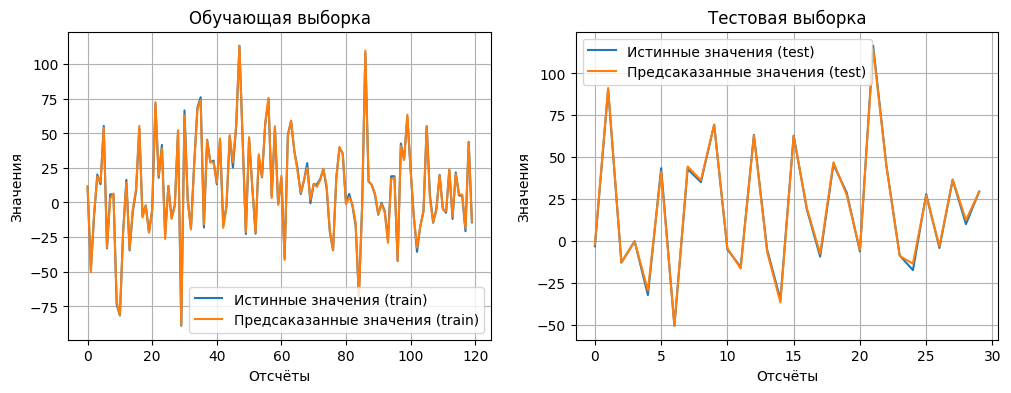

In [55]:
regressor = GradientDescent(x_train, y_train, eta=1e-3)
ry_train, ry_test = regressor(x_train), regressor(x_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
ax0.plot(y_train, label='Истинные значения (train)')
ax0.plot(ry_train, label='Предсаказанные значения (train)')
ax0.set(xlabel='Отсчёты', ylabel='Значения', title='Обучающая выборка')
ax0.legend()


ax1.plot(y_test, label='Истинные значения (test)')
ax1.plot(ry_test, label='Предсаказанные значения (test)')
ax1.set(xlabel='Отсчёты', ylabel='Значения', title='Тестовая выборка')
ax1.legend()

print('Ошибка на обучающей выборке', sk.metrics.mean_squared_error(y_train, ry_train))
print('Ошибка на тестовой выборке', sk.metrics.mean_squared_error(y_test, ry_test))
print('Статистика:', regressor.last_iter, regressor.last_error, regressor.last_error_delta)


**Вопросы**:

1. Стали ли результаты лучше метода наименьших квадратов из предыдущего пункта?
1. Как параметр $\eta$ влияет на количество итераций?
1. Найдите примерное значение $\eta$, после которого метод расходится (ошибка возрастает, а не уменьшается)?

**Ответы:**

1. Мы получили результат не лучше, чем в предыдущем пункте
2. Данный параметр сокращает количество итераций при возрастании
3. Начиная с $1e-3$ метод начинает расходится. Это происходит из-за того, что каждый шаг спуска начинает перепрыгивать через нужную нам точку

## Задание №4

Сгенерируйте датасет с нелинейными данными:

* $x$ - это вектор из 15 элементов, значения которого распределены равномерно на интервале $[-1; 1]$;
* $y$ - это синусоида от значений $x$, смещенных на $0.7$, к которой прибавлен шум в виде нормального распределения $N(0.1, 0.2)$;
* выделите из полученных данных обучающую и тестовую выборки.
Размер тестовой выборки составляет 20%.

(12, 1) (12,)


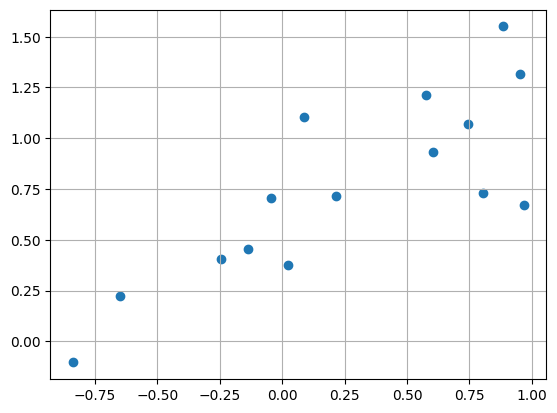

In [56]:
rng = np.random.default_rng(seed=4)
x = rng.uniform(low=-1.0, high=1.0, size=(15, 1))
y = (np.sin(x + 0.7) + rng.normal(loc = 0.1, scale = 0.2, size=(len(x), 1))).reshape(-1)
plt.scatter(x, y)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=43, test_size = 0.2)
print(x_train.shape, y_train.shape)

Примените один из предыдущих методов на полученном датасете.
Постройте гистограмму ошибок предсказания, полученных на обучающих и тестовых данных.
Дайте оценку качеству предсказания, оценивая его по величине MSE.

Ошибка на обучающей выборке: 0.05834647108638752
Ошибка на тестовой выборке: 0.11544998770866098


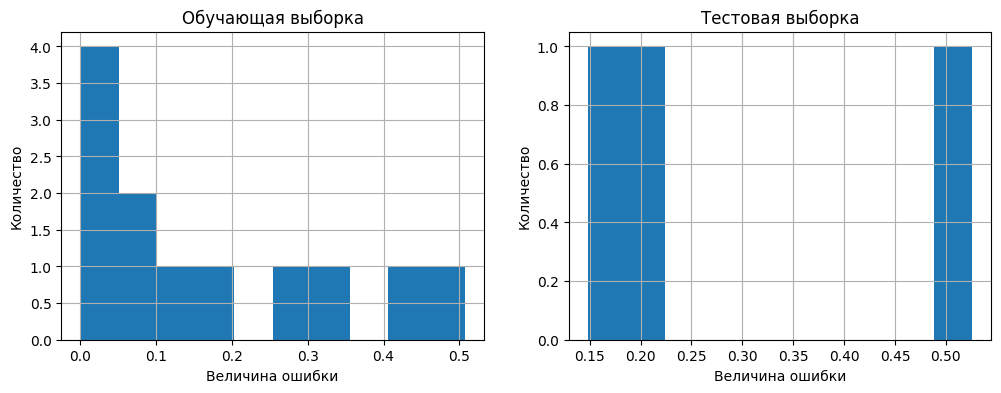

In [57]:
regressor = GradientDescent(x_train, y_train)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
ry_train = regressor(x_train)
ry_test = regressor(x_test)
ax0.hist(np.abs(ry_train - y_train))
ax0.set(xlabel='Величина ошибки', ylabel='Количество', title='Обучающая выборка')
ax1.hist(np.abs(ry_test - y_test))
ax1.set(xlabel='Величина ошибки', ylabel='Количество', title='Тестовая выборка')

print('Ошибка на обучающей выборке:', sk.metrics.mean_squared_error(y_train, ry_train))
print('Ошибка на тестовой выборке:', sk.metrics.mean_squared_error(y_test, ry_test))

## Задание №5

Создайте функцию-декоратор для добавления степенной зависимости в произвольную модель регрессии.

In [58]:
def PolyDecorator(clazz, *args, **kwargs):
    class PolyDecoratorClass(clazz):
        def __init__(self, p, x, *args):
            super().__init__(PolyDecoratorClass.poly(x, p), *args)
            self.p = p
        
        def __call__(self, x):
            return super().__call__(PolyDecoratorClass.poly(x, self.p))
        
        @staticmethod
        def poly(x, k):
            return np.concatenate([x ** p for p in range(1, k + 1)], axis=1)

    return PolyDecoratorClass(*args, **kwargs)

Попробуйте улучшить результат для датасета.
Используйте модель
$$
y_{pred} = w_0 + w_1 x + w_2 x^2 + \dots + w_p x^p.
$$

Рассмотрите полиномы порядков $p$ от 1 до 9.

Как порядок влияет на качество?
Чтобы ответить на этот вопрос, нужно привести значения MSE для обучающей и тестовой выборок в виде графика
(зависимость MSE-ошибки $E$ от порядка полинома $p$).
Выберите наилучшую модель.

Порядок: 2, ошибка на тестовой выборке: 0.09999501834110212


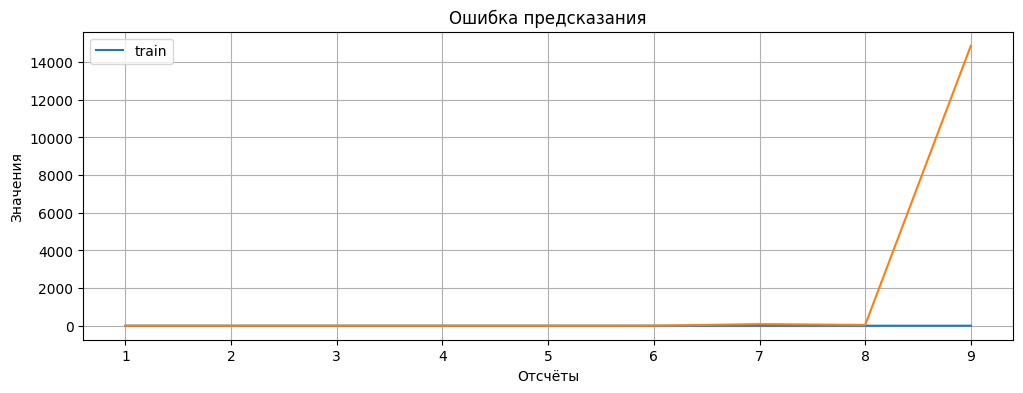

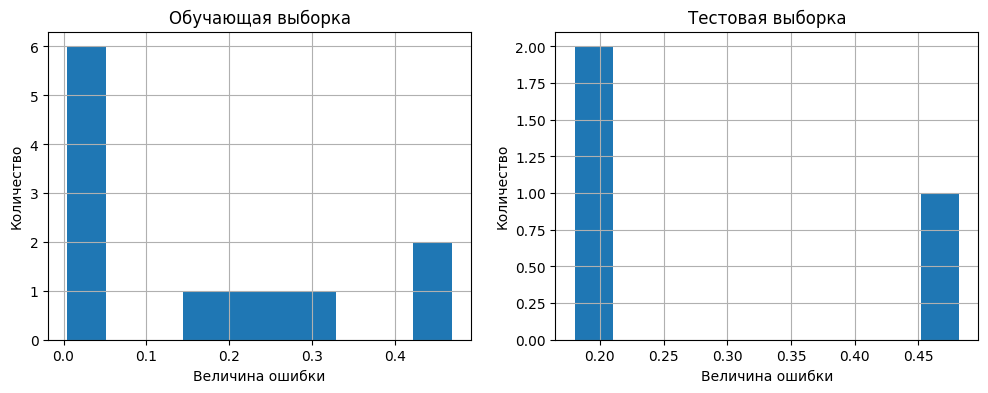

In [65]:
powers = np.arange(1, 10)
train_err, test_err, regr = [], [], []
for p in powers:
    regressor = PolyDecorator(LeastSquare, p, x_train, y_train)
    train_err.append(sk.metrics.mean_squared_error(y_train, regressor(x_train)))
    test_err.append(sk.metrics.mean_squared_error(y_test, regressor(x_test)))
    regr.append(regressor)

fig, ax = plt.subplots(1, 1, figsize=(2*6, 4))
ax.plot(powers, train_err, label='train')
ax.plot(powers, test_err)
ax.set(xlabel='Отсчёты', ylabel='Значения', title='Ошибка предсказания')
ax.legend()

k = np.argmin(test_err)
best_regr = regr[k]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
ax0.hist(np.abs(best_regr(x_train) - y_train))
ax0.set(xlabel='Величина ошибки', ylabel='Количество', title='Обучающая выборка')
ax1.hist(np.abs(best_regr(x_test) - y_test))
ax1.set(xlabel='Величина ошибки', ylabel='Количество', title='Тестовая выборка')

print(f"Порядок: {powers[k]}, ошибка на тестовой выборке: {test_err[k]}")

**Вопросы:**

1. Удалось ли с полиномиальной регрессией достичь лучших результатов, чем с линейной регрессией?

**Ответы:**

1. Да, при повышении степени в разумных пределах модель способна распознать более сложные зависимости, что положительно влияет на её точность

## Задание №6

Добавьте $L2$-регуляризацию для модели из пункта 5
$$
E_r = \frac{1}{2} \sum_{n=0}^{N-1} \left( t_n - \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) \right)^2 + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}.
$$

Для этого отнаследуйтесь от регрессора и переопределите его конструктор.

In [66]:
class LeastSquareMod(LeastSquare):
    def __init__(self, x, y, alpha):
        ones = np.ones((len(y),1))
        x = np.concatenate((ones, x), axis = 1)
        self.w = np.linalg.inv(x.T @ x + alpha * np.eye(x.shape[1])) @ x.T @ np.array(y).T

Подберите параметр регуляризации.
Для этого постройте heat-карту, показывающую значение MSE в зависимости от порядка полинома $p$ и значения параметра регуляризации $\lambda$.

C:\Users\EReshetnikov\AppData\Local\Temp\ipykernel_12892\1434974966.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im0, ax=ax0)
C:\Users\EReshetnikov\AppData\Local\Temp\ipykernel_12892\1434974966.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im1, ax=ax1)


Порядок: 2, параметр alpha: 1e-06, ошибка на тестовой выборке: 0.16509475699094128


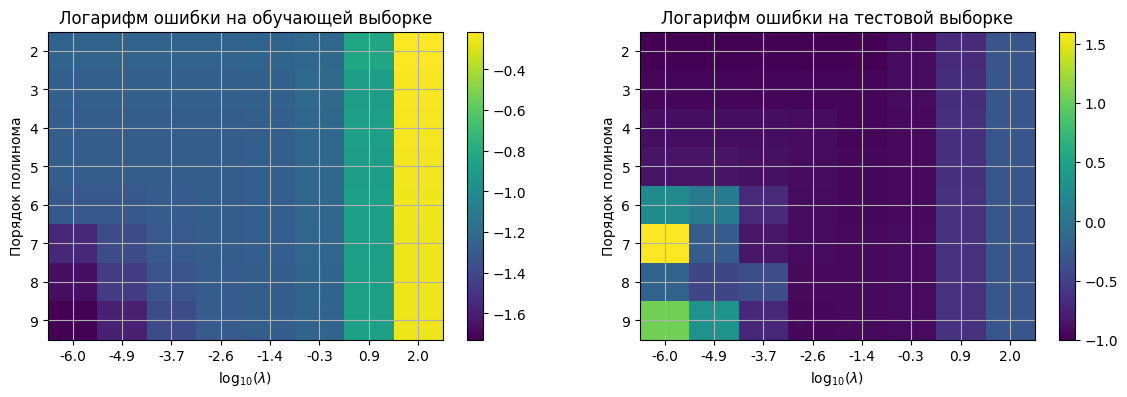

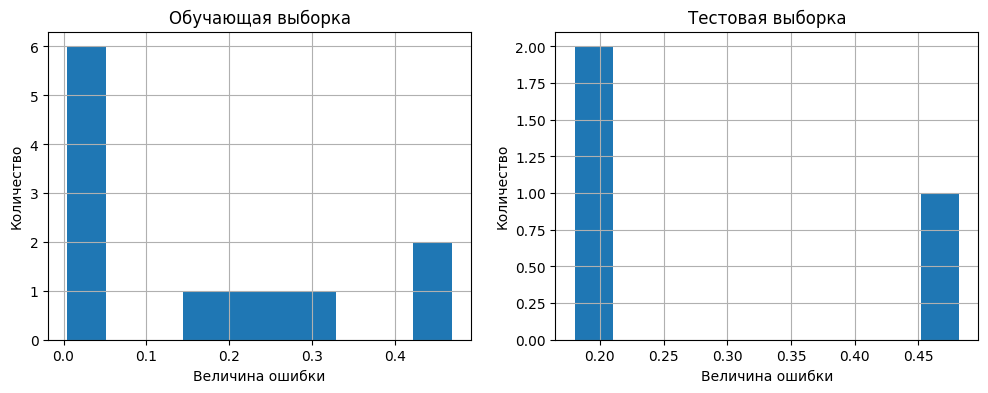

In [70]:
powers = np.arange(2, 10)
alphas = np.logspace(-6, 2, 8)
err = np.zeros((len(powers), len(alphas)))
errt = err.copy()
regr = []
for i, p in enumerate(powers):
    for j, a in enumerate(alphas):
        regressor = PolyDecorator(LeastSquareMod, p, x_train, y_train, a)
        err[i][j] = sk.metrics.mean_squared_error(y_train, regressor(x_train))
        errt[i][j] = sk.metrics.mean_squared_error(y_test, regressor(x_test))
        regr.append(regressor)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*7, 4))
im0 = ax0.imshow(np.log10(err), cmap='viridis', aspect='auto')
ax0.set(xlabel='$\log_{10}(\lambda)$', ylabel='Порядок полинома', title='Логарифм ошибки на обучающей выборке')
ax0.set(xticks=range(len(alphas)), xticklabels=np.log10(alphas).round(decimals=1))
ax0.set(yticks=range(len(powers)), yticklabels=powers)
fig.colorbar(im0, ax=ax0)

im1 = ax1.imshow(np.log10(errt), cmap='viridis', aspect='auto')
ax1.set(xlabel='$\log_{10}(\lambda)$', ylabel='Порядок полинома', title='Логарифм ошибки на тестовой выборке')
ax1.set(xticks=range(len(alphas)), xticklabels=np.log10(alphas).round(decimals=1))
ax1.set(yticks=range(len(powers)), yticklabels=powers)
fig.colorbar(im1, ax=ax1)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
k = np.argmin(errt)
best_regr = regr[k]
ax0.hist(abs(best_regr(x_train) - y_train))
ax0.set(xlabel='Величина ошибки', ylabel='Количество', title='Обучающая выборка')
ax1.hist(abs(best_regr(x_test) - y_test))
ax1.set(xlabel='Величина ошибки', ylabel='Количество', title='Тестовая выборка')

print(f"Порядок: {powers[k]}, параметр alpha: {alphas[k]}, ошибка на тестовой выборке: {errt[k].mean()}")

**Вопросы**:

1. Какая модель (с регуляризацией или без) даёт лучшие результаты?
1. Получилось ли достичь лучших результатов при меньшем порядке полинома? 
1. Наблюдалось ли переобучение модели, и было ли оно устранено введением регуляризации?

**Ответы:**

1. Без регуляризации ответ получается более точным, но регуляризация направлена на то, чтобы уберечь нас от переобучения и избавиться от лишних зависимостей. Её применение не всегда может приводить к улучшению результат.

1Нет..
1Да, это видно по гистрограмме..